In [80]:
# Checkout www.pygimli.org for more examples


# Based on pg example notebook:  3D gravity modelling and inversion

Based on the synthetic model of Li & Oldenburg (1998), we demonstrate 3D
inversion of magnetic data. The forward operator bases on the formula given by
Holstein et al. (2007).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer import pv
from pygimli.utils.utils import ProgressBar
import pandas as pd
    

In [2]:
from pygimli.viewer.pv import drawStreamLines, drawSlice

In [3]:
class GravityModelling(pg.frameworks.MeshModelling):
    """Magnetics modelling operator using Holstein (2007)."""

    def __init__(self, mesh, points, cmp=["gz"], foot=None):
        """Setup forward operator.

        Parameters
        ----------
        mesh : pygimli:mesh
            tetrahedral or hexahedral mesh
        points : list|array of (x, y, z)
            measuring points
        cmp : list of str
            component of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
        """
        # check if components do not contain g!
        super().__init__(mesh=mesh)
        self.createRefinedForwardMesh(refine=False, pRefine=False)
        self.mesh_ = mesh
        self.sensorPositions = points
        self.components = cmp
        self.footprint = foot
        self.kernel = None
        self.J = pg.matrix.BlockMatrix()
        self.createKernel()

    def createKernel(self):
        """Create computational kernel."""
        self.kernel = SolveGravMagHolstein(self.mesh_,
                                           pnts=self.sensorPositions,
                                           cmp=self.components,
                                           foot=self.footprint)
        self.J = pg.matrix.BlockMatrix()
        self.Ki = []
        self.Ji = []
        for iC in range(self.kernel.shape[1]):
            self.Ki.append(np.squeeze(self.kernel[:, iC, :]))
            self.Ji.append(pg.matrix.NumpyMatrix(self.Ki[-1]))
            self.J.addMatrix(self.Ji[-1], iC*self.kernel.shape[0], 0)

        self.J.recalcMatrixSize()
        self.setJacobian(self.J)


    def setMesh(self, mesh, ignoreRegionManager=False):
        """Set the mesh."""
        super().setMesh(mesh, ignoreRegionManager=False)
        self.createKernel(mesh)


    def response(self, model):
        """Compute forward response."""
        return self.J.dot(model)

    def createJacobian(self, model):
        """Do nothing as this is a linear problem."""

In [4]:
def SolveGravMagHolstein(mesh, pnts, cmp, igrf=None, foot=np.inf):
    """Solve gravity and/or magnetics problem after Holstein (1997).

    Parameters
    ----------
    mesh : pygimli:mesh
        tetrahedral or hexahedral mesh
    pnts : list|array of (x, y, z)
        measuring points
    cmp : list of str
        component list of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
    igrf : list|array of size 3 or 7
        international geomagnetic reference field, either
        [D, I, H, X, Y, Z, F] - declination, inclination, horizontal field,
                               X/Y/Z components, total field OR
        [X, Y, Z] - X/Y/Z components

    Returns
    -------
    out : ndarray (nPoints x nComponents x nCells)
        kernel matrix to be multiplied with density or susceptibility
    """
    if pnts is None:
        pnts = [[0.0, 0.0]]

    doG = np.any([c[0] == "g" for c in cmp])
    doB = np.any([c[0] == "B" and len(c) == 2 for c in cmp]) or "TFA" in cmp
    doBT = np.any([c[0] == "B" and len(c) == 3 for c in cmp])
    B_tens = None

    kernel = np.zeros((mesh.cellCount(), len(pnts), len(cmp)))
    if igrf:
        if len(igrf) == 3:  # an X, Y, Z vector
            F = np.linalg.norm(igrf)
            fakt = F / (4*np.pi)
            B_dir = np.array(igrf) / F
        elif len(igrf) == 7:  # an IGRF vector (D, I, H, X, Y, Z, F)
            fakt = igrf[6] / (4*np.pi)
            myigrf = np.array(igrf[3:6])
            B_dir = myigrf / np.linalg.norm(myigrf)
        else:
            raise Exception("Could not use IGRF vector. Len must be 3 or 7!")
    elif doB or doB:
        raise Exception("Specify IGRF!")

    b_list, c_list = [], []
    for bd in mesh.boundaries():
        b_list.append([n.id() for n in bd.allNodes()])
        c_list.append([bd.leftCell(), bd.rightCell()])

    b_list = np.array(b_list)
    lb = b_list.shape

    n_list = np.array([n.pos() for n in mesh.nodes()])

    cl, cr = [], []
    for i, c in enumerate(c_list):
        if c[0]:
            cl.append([i, c[0].id()])
        if c[1]:
            cr.append([i, c[1].id()])

    cl = np.array(cl)
    cr = np.array(cr)

    rr = range(0, mesh.cellCount())
    rs = np.roll(range(0, lb[1]), -1)

    temp = np.zeros((len(pnts), lb[0], len(cmp)))
    pBar = ProgressBar(its=len(pnts), width=40, sign='+')
    nb = n_list[b_list]
    for i, p in enumerate(pnts):
        r1 = nb - p
        r2 = r1[:, rs, :]
        r0 = r2 - r1
        u = np.sum(np.cross(r1, r2), 1)
        u = u / np.expand_dims(np.linalg.norm(u, axis=1), axis=1)
        ut = np.tile(u, lb[1]).reshape((lb[0], lb[1], 3))
        ll = np.linalg.norm(r0, axis=2)
        t = r0/np.expand_dims(ll, axis=2)
        lm = (np.sum(r1*t, 2) + np.sum(r2*t, 2)) / 2
        h = np.cross(t, ut)
        hn = np.sum(h*r1, 2)
        v = np.sum(ut*r1, 2)
        r1n = np.linalg.norm(r1, axis=2)
        r2n = np.linalg.norm(r2, axis=2)
        rm = (r1n+r2n)/2
        lumbda = ll/(2*rm)

        jj = 0
        if doG: # gravitational field
            g = hn*np.arctanh(lumbda)-np.sign(v)*v*np.arctan2(
                hn*lumbda, (rm*(1-lumbda**2)+abs(v)))
            g_vec = 2 * u * np.expand_dims(np.sum(g, 1), axis=1)

            if 'g' in cmp:
                temp[i, :, jj] = g
                jj += 0

            if 'gx' in cmp:
                temp[i, :, jj] = g_vec[:, 0]
                jj += 1

            if 'gy' in cmp:
                temp[i, :, jj] = g_vec[:, 1]
                jj += 1

            if 'gz' in cmp:
                temp[i, :, jj] = g_vec[:, 2]
                jj += 1

            # if 'gxx' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 0]
            # if 'gxy' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 1]
            # if 'gxz' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 2]
            # if 'gyy' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 1]
            # if 'gyz' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 2]
            # if 'gzz' in cmp:
            #     temp[:, jj]=G_tens[:, 2, 2]

        if doB or doBT:
            # magnetic field vector and gravity gradient tensor
            b = h*np.expand_dims(np.arctanh(lumbda), axis=2) - \
                ut*np.expand_dims(np.sign(v)*np.arctan2(
                    hn*lumbda, (rm*(1-lumbda**2)+abs(v))), axis=2)
            P = np.dot(u, B_dir)
            B_vec = np.expand_dims(P, 1) * np.sum(b, 1)
            B_vec = 2 * np.expand_dims(P, 1) * np.sum(b, 1)

            if 'TFA' in cmp:
                temp[i, :, jj] = fakt*B_vec.dot(B_dir)
                jj += 1

            if 'Bx' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 0]
                jj += 1

            if 'By' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 1]
                jj += 1

            if 'Bz' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 2]
                jj += 1

            if doBT:  # magnetic gradient tensor
                d = (-2*lumbda*hn) / (r1n*r2n*(1-lumbda**2))
                e = (-2*lumbda*lm) / (r1n*r2n)
                f = (-2*lumbda*v) / (r1n*r2n*(1-lumbda**2))

                h1 = np.expand_dims(h, axis=3)
                h2 = np.swapaxes(h1, 2, 3)
                t1 = np.expand_dims(t, axis=3)
                t2 = np.swapaxes(t1, 2, 3)
                u1 = np.expand_dims(ut, axis=3)
                u2 = np.swapaxes(u1, 2, 3)

                B = (h1*h2-u1*u2)*np.expand_dims(d, (2, 3)) + \
                    (t1*h2+h1*t2)*np.expand_dims(e, (2, 3))/2 + \
                    (h1*u2+u1*h2)*np.expand_dims(f, (2, 3))

                B_tens = np.expand_dims(P, (1, 2)) * np.sum(B, 1)

                if 'Bxx' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 0]
                    jj += 1

                if 'Bxy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 1]
                    jj += 1

                if 'Bxz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 2]
                    jj += 1

                if 'Byy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 1]
                    jj += 1

                if 'Byz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 2]
                    jj += 1

                if 'Bzz' in cmp:
                    temp[i, :, jj] = fakt * B_tens[:, 2, 2]
                    jj += 1

    pBar.update(i)
    kernel += np.array([np.sum(temp[:, cl[cl[:, 1] == j, 0]], 1) for j in rr])
    kernel -= np.array([np.sum(temp[:, cr[cr[:, 1] == j, 0]], 1) for j in rr])

    return kernel.transpose([1, 2, 0])

## Synthetic model generation and data import





In [5]:
#service desk suggestion so that the figures run on cluster 
import pyvista
pyvista.start_xvfb() 


In [6]:
#dataset = pd.read_csv('C:/RWTH_Aachen/thesis/july_bash/gravity_processed.csv')
dataset = pd.read_csv('gravity_processed.csv')

In [7]:
#gravity data import - processed data from straelen 
#bouger anomaly corrected - background density 2400 g/cc
d_obs_x = dataset['CORRECTEDx']
d_obs_y = dataset['CORRETED']
d_obs_z = dataset['Ele_tiff']
d_obs_grav  = dataset['abs_Grav'] - dataset['gravity_bouger_corrected2400']
d_obs = {'X': d_obs_x, 'Y': d_obs_y, 'Z': d_obs_z, 'abs_grav': dataset['abs_Grav'], 'bouger anomaly': dataset['gravity_bouger_corrected2400']}
df = pd.DataFrame(d_obs)
df

X            Y        Z     abs_grav  bouger anomaly
0    218366.5117  381192.5130  41.4175  981184.4800       -2.872241
1    218569.6151  381290.6376  38.6000  981185.3003       -2.713735
2    218743.2993  381370.5864  37.0550  981186.0181       -2.379002
3    218878.7973  381323.1159  35.9175  981186.2231       -2.371430
4    219216.5121  381365.4320  32.1200  981186.9409       -2.473579
..           ...          ...      ...          ...             ...
119  216181.9902  384866.4828  40.0075  981187.2586       -3.324757
120  215712.4380  384844.2620  43.1650  981185.8204       -4.093230
121  215180.8298  384919.1373  45.4475  981184.3324       -5.171050
122  214748.6012  385009.7034  36.3500  981184.5869       -6.884321
123  214342.7288  385427.2817  32.4675  981184.2778       -8.336058

[124 rows x 5 columns]

In [8]:
max(d_obs_x), min(d_obs_x), 

(219636.4017, 212508.4086)

In [9]:
max(d_obs_y), min(d_obs_y), 

(387729.2017, 380750.5025)

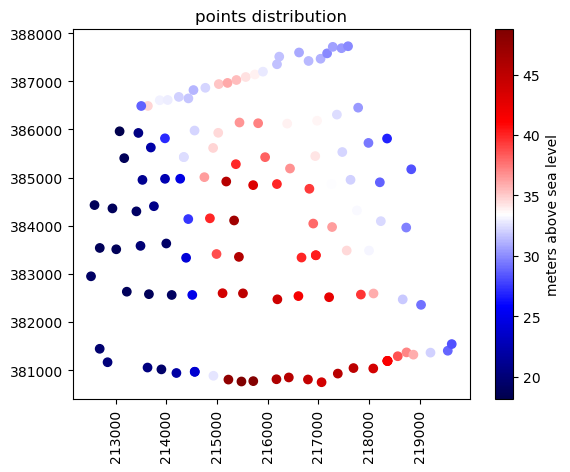

In [10]:
#observed data
plt.scatter(df['X'], df['Y'], c=df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()
plt.show()

In [11]:
d_obs_x = dataset['CORRECTEDx']
d_obs_y = dataset['CORRETED']
d_obs_z = dataset['Ele_tiff']
d_obs_grav  = dataset['abs_Grav'] - dataset['gravity_bouger_corrected2400']
d_obs = {'X': d_obs_x, 'Y': d_obs_y, 'Z': d_obs_z, 'abs_grav':
         dataset['abs_Grav'], 'bouger anomaly': dataset['gravity_bouger_corrected2400'],
        'ID':dataset['Point ID'], }
df = pd.DataFrame(d_obs)

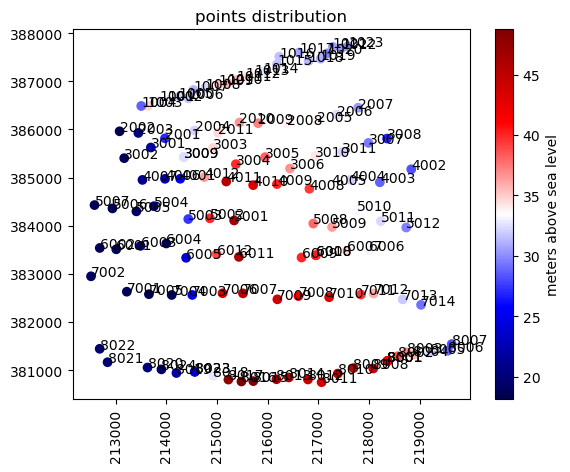

In [12]:
#observed data
for i, txt in enumerate(df['ID']):
    plt.annotate(txt, (df['X'][i], df['Y'][i]))

plt.scatter(df['X'], df['Y'], c=df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()
plt.show()


In [13]:
#taking the size of the survey
dx = 250
dy = 250
dz = 250
xmin = 212000
xmax = 220001
ymin = 380000
ymax = 388001
zmin = 0.
zmax = 2501
x = np.arange(xmin, xmax, dx)
y = np.arange(ymin, ymax, dy)
z = np.arange(zmin, zmax, dz)
grid = pg.createGrid(x, y, z)
print(grid)


Mesh: Nodes: 11979 Cells: 10240 Boundaries: 32384


In [14]:
len(x)

33

In [15]:
len(y)

33

In [16]:
len(z)

11

(array([212000., 213000., 214000., 215000., 216000., 217000., 218000.,
        219000., 220000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

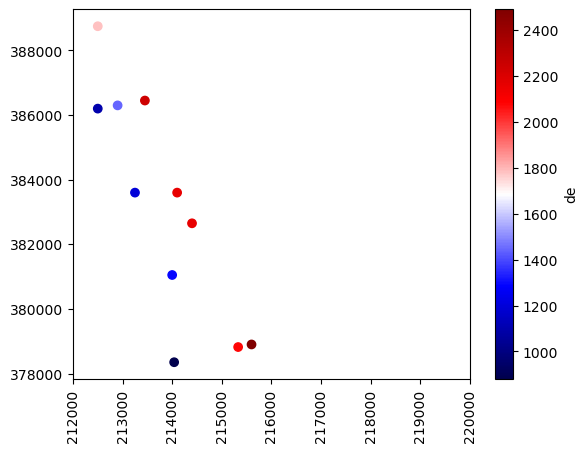

In [17]:
#some point locations of Viersen Fault

a =(
[214040,378350,880],
[215330,378820,2080],
[215600,378900,2490],
[214000,381050,1290],
[214400,382650,2160],
[213250,383600,1195],
[214100,383600,2160],
[212500,386200,1100],
[212900,386300,1440],
[213450,386450,2240],
[212500,388750,1780])

A=np.array(a)
Ax = A[:, 0]
Ay = A[:, 1]
Az = A[:, 2]

plt.scatter(Ax, Ay, c=Az,  cmap='seismic')
plt.xlim(212000, 220000)
plt.colorbar(label="de")
plt.xticks(rotation=90)

In [18]:
#Density distribution 
v = np.zeros((len(z)-1, len(y)-1, len(x)-1))
v[0:4]=3500
v[4:7]=2800
v[7:9]=2650
v[9]=2600

#for i in range(0, 33):
 # 
  #  v[8, (0+2*i):33, (15-i):33]=2600
   # v[6, (0+2*i):33, (13-i):33]=2650
    #v[3, (0+2*i):33, (12-i):33]=2800
#

v[0:10]=2400   
grid["synth"] = v.ravel()


We show the model making use of the pyvista package that can be called by
:py:func:`pygimli.show`. The mesh itself is shown as a wireframe, the anomaly
is plotted as a surface plot using a threshold filter. After the first call
with ``hold=True``, the plotter is used to draw any subsequent plots that can
also be slices or clips. Moreover, the camera position is set so that the
vertical axis is going downwards (x is Northing and y is Easting as common in
magnetics).




In [19]:
#pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.1)
#pv.drawMesh(pl, grid, label="synth", style="surface", cMap="Spectral_r",
#            filter={"threshold": dict(value=1, scalars="synth")})#
#
##camera = dict(
  #  center=dict(x=0, y=0, z=0.7))
#_ = pl.show()

In [20]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.3)
pv.drawMesh(pl, grid, label="synth", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
_ = pl.show()

2023-07-30 11:34:20.277 (   7.191s) [        FA0FA200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


In [21]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.1)
pv.drawMesh(pl, grid, label="synth", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

2023-07-30 11:34:23.988 (  10.902s) [        FA0FA200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


In [22]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.1)
pv.drawMesh(pl, grid, label="synth", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 215
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

2023-07-30 11:34:24.788 (  11.702s) [        FA0FA200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


For the computation of the total field, we define the global magnetic
field using the IGRF (total field, inclination and declination) settings
given in the paper. Any global field can also be retrieved by the
``pyIGRF`` module.




In [23]:
#error estimation
#what about d_pre? taking the forward model
#for now default 
err = 1e-7
noise_level = 1e-4
relError = noise_level / np.abs(d_obs_grav) + err
d_obs_grav *= np.random.randn(*d_obs_grav.shape)*relError + 1.0

In [24]:
relError

0      1.001019e-07
1      1.001019e-07
2      1.001019e-07
3      1.001019e-07
4      1.001019e-07
           ...     
119    1.001019e-07
120    1.001019e-07
121    1.001019e-07
122    1.001019e-07
123    1.001019e-07
Length: 124, dtype: float64

In [25]:
#arranging data for the forward operator
d_obs_x=np.array(d_obs_x)
d_obs_y=np.array(d_obs_y)
d_obs_bouger=np.array(df['bouger anomaly'])


In [26]:
#original approax for forward operator
xx, yy = np.meshgrid(x, y)
points = np.column_stack((xx.ravel(), yy.ravel(), -np.ones(np.prod(xx.shape))))

In [27]:
points

array([[ 2.1200e+05,  3.8000e+05, -1.0000e+00],
       [ 2.1225e+05,  3.8000e+05, -1.0000e+00],
       [ 2.1250e+05,  3.8000e+05, -1.0000e+00],
       ...,
       [ 2.1950e+05,  3.8800e+05, -1.0000e+00],
       [ 2.1975e+05,  3.8800e+05, -1.0000e+00],
       [ 2.2000e+05,  3.8800e+05, -1.0000e+00]])

30/07/23 - 11:34:26 - Core - INFO - copy mesh for forward tasks.


   0%|          |0/1089 [00:00 < ?]

(array([212000., 213000., 214000., 215000., 216000., 217000., 218000.,
        219000., 220000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

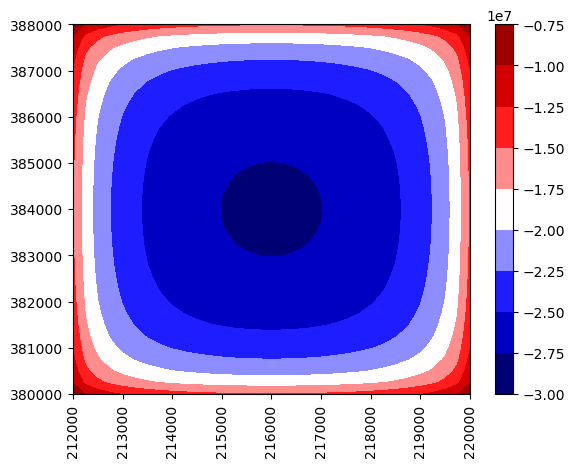

In [28]:
#forward operator based on the regular grid of points
fop = GravityModelling(grid, points)
data = fop.response(grid["synth"])
noise_level = 0.1
data += np.random.randn(len(data)) * noise_level
plt.contourf(xx, yy, np.reshape(data, xx.shape), cmap='seismic')
#plt.scatter(d_obs_x, d_obs_y, c=data, cmap='seismic')
plt.colorbar();
plt.xticks(rotation=90)

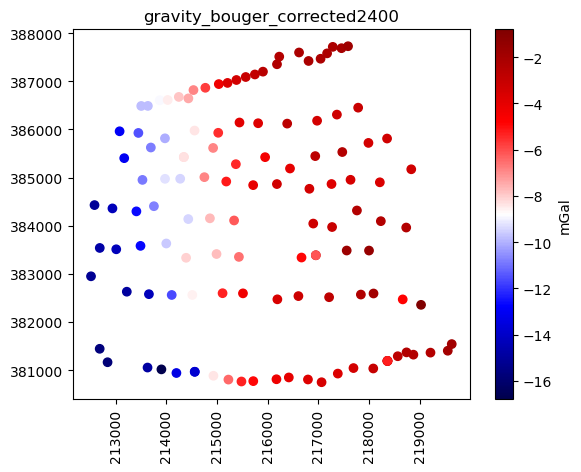

In [29]:
#observed bouger
plt.scatter(df['X'], df['Y'], c=d_obs_bouger, cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2400')
plt.plot()
plt.show()

In [30]:
points2 = np.column_stack((d_obs_x, d_obs_y, d_obs_bouger))

In [31]:
rd=np.random.randn(len(data))
rd

array([-0.70528962, -0.9771042 ,  0.37902492, ..., -0.94311859,
       -0.5855943 , -0.06645384])

30/07/23 - 11:35:22 - Core - INFO - copy mesh for forward tasks.


   0%|          |0/124 [00:00 < ?]

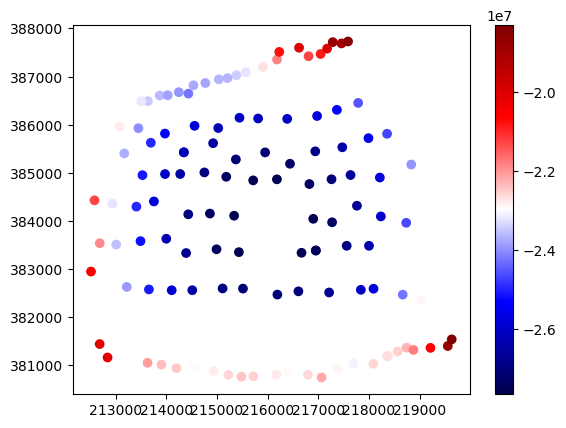

In [32]:
# forward operator based on the locations of the stations 
fop2 = GravityModelling(grid, points2)
data = fop2.response(grid["synth"])
noise_level = 0.1
data += np.random.randn(len(data)) * noise_level
#plt.contourf(xx, yy, np.reshape(data, xx.shape), cmap='seismic')
plt.scatter(d_obs_x, d_obs_y, c=data, cmap='seismic')
plt.colorbar();

In [33]:
data

124 [-22680132.84818863,...,-26250650.234439794]

## Depth weighting

In the paper of Li & Oldenburg (1996), they propose a depth weighting of the
constraints with the formula

\begin{align}w_z = \frac{1}{(z+z_0)^{3/2}}\end{align}




In [34]:
# depth weighting
bz = np.array([b.center().z() for b in grid.boundaries() if not b.outside()])
bn = np.array([b.norm().z() for b in grid.boundaries() if not b.outside()])
z0 = 100
wz = z0 / (bz+z0)**1
# wz = z0 / (pg.z(grid.cellCenters())+z0)

## Inversion

The inversion is rather straightforward using the standard inversion
framework :py:class:`pygimli.Inversion`.




In [35]:
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
#inv.modelTrans = pg.trans.TransCotLU(-2, 2)
#inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=3e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

30/07/23 - 11:35:31 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.GravityModelling object at 0x14ece2370540>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14ed40298e20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x14ece2370770>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 29056 x 10240
calculating jacobian matrix (forced=1)...... 1.3695e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log)

In [75]:
inv.chi2History




[9999.166684028205,
 9913.35821149384,
 8729.73475461882,
 2056.63183414001,
 57.72732085303784,
 0.12247684771475209]

In [76]:
inv.modelHistory

[array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]),
 10240 [9.924141647633098,...,10.114638267380306],
 10240 [159.61597330468535,...,165.57505350498826],
 10240 [1287.9342055069142,...,1292.039421123946],
 10240 [2190.081255397993,...,2196.6621860017176],
 10240 [2408.658952149563,...,2405.185399065181]]

In [80]:
len(inv.modelHistory[1])

10240

In [77]:
inv.startModel


10240 [-24222846.366531715,...,-24222846.366531715]

In [74]:
inv.response

124 [-22768384.967314016,...,-26339501.629747976]

In [81]:
for model in inv.modelHistory:
    print(model)

[0.1 0.1 0.1 ... 0.1 0.1 0.1]
10240 [9.924141647633098,...,10.114638267380306]
10240 [159.61597330468535,...,165.57505350498826]
10240 [1287.9342055069142,...,1292.039421123946]
10240 [2190.081255397993,...,2196.6621860017176]
10240 [2408.658952149563,...,2405.185399065181]


data_misfit
124 [88252.11912538484,...,88851.39530818164]
mean data_misfit
84860.08691962755
min data_misfit
61602.421131338924
max data_misfit
95508.44629518688


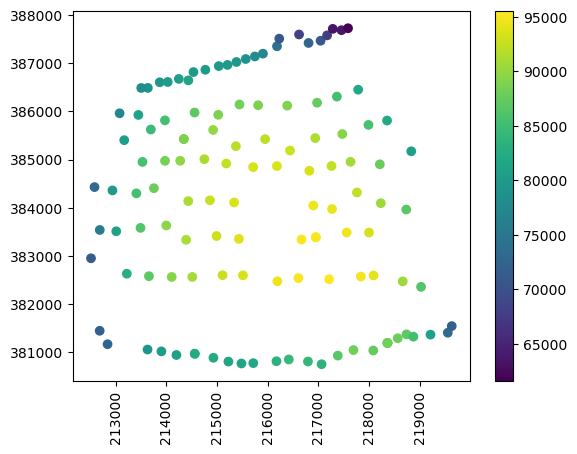

In [39]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

data_misfit
124 [7185.099296964705,...,4704.765763718635]
mean data_misfit
5193.762708787446
min data_misfit
2982.7126221843064
max data_misfit
7185.099296964705


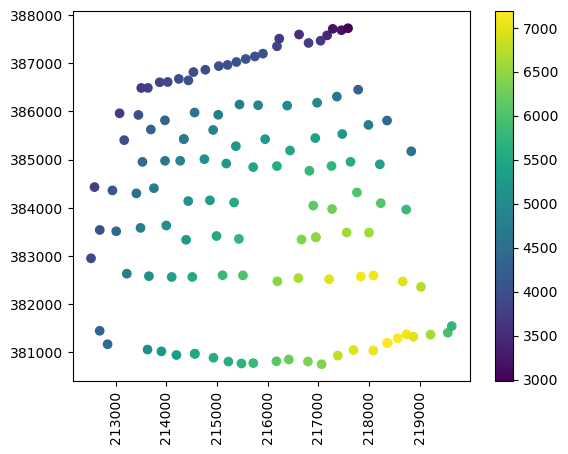

In [32]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

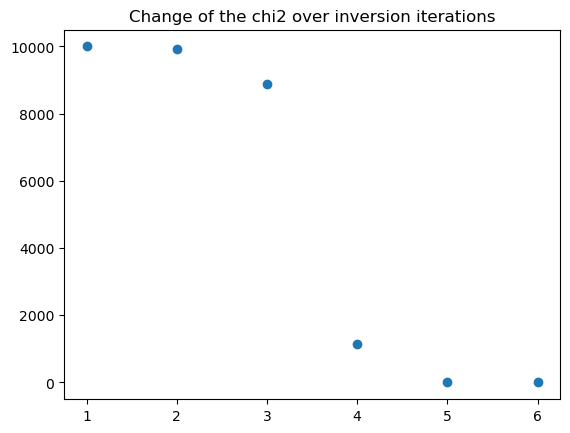

In [33]:
Ichi2=inv.chi2History
len(Ichi2)
n = len(Ichi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,Ichi2)


In [34]:
Ichi2

[9999.166684027845,
 9914.759579775788,
 8887.19322632475,
 1139.2824718645022,
 4.798925590462607,
 0.00136670253723811]

In [34]:
Ichi2

[9999.166684027743,
 9915.131954076474,
 8924.854870228528,
 891.6202753211655,
 2.5110376522423725,
 0.00048158996588280336]

In [35]:
min(grid['inv']), max(grid['inv'])

(2399.3427919432293, 2401.1916455727405)

In [35]:
min(grid['inv']), max(grid['inv'])

(2399.4034414102975, 2401.7947241980646)

## Visualization

For showing the model, we again use the threshold filter with a value of
0.02. For comparison with the synthetic model, we plot the latter as a
wireframe.




2023-07-30 11:50:22.696 ( 969.610s) [        FA0FA200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


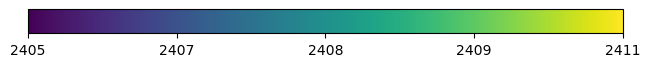

In [62]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

2023-07-29 19:15:19.879 ( 214.081s) [        B5302200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


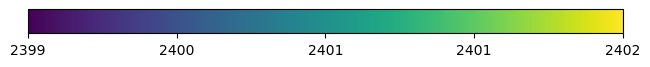

In [36]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

2023-07-29 19:00:14.531 ( 201.715s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.
2023-07-29 19:00:14.702 ( 201.886s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


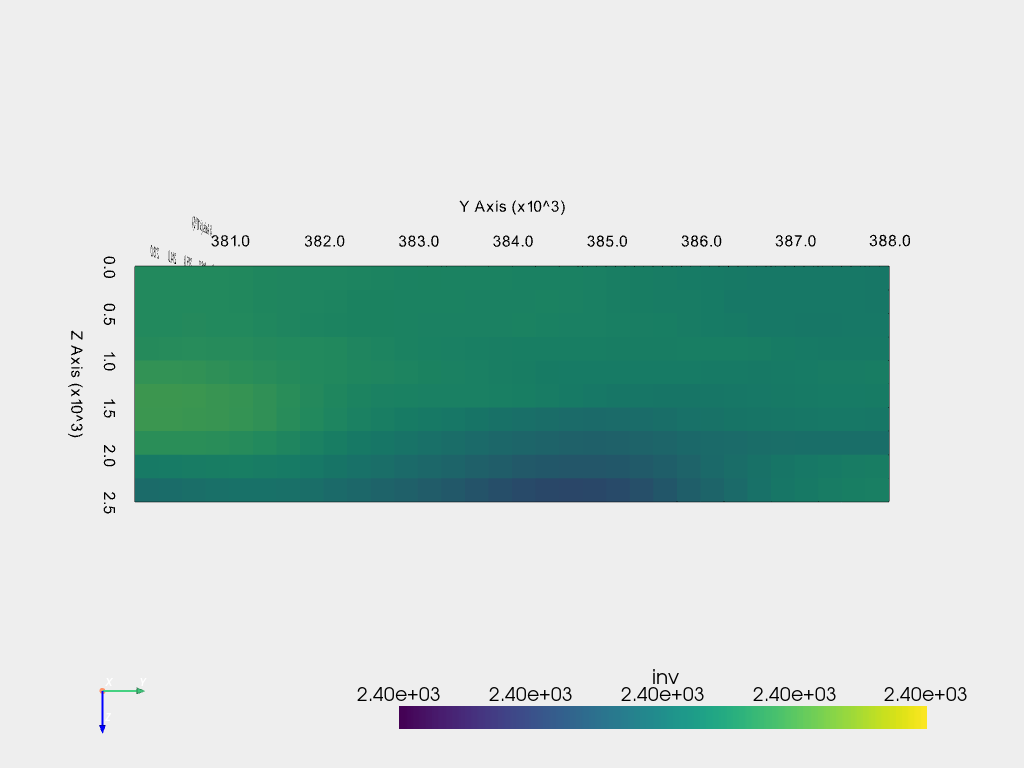

In [37]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180
pl.camera.zoom(1.2)
_ = pl.show()

The model can outline the top part of the anomalous body and its lateral extent,
but not its depth extent due to the ambiguity of gravity.
We use a vertical slice to illustrate that.




2023-07-29 19:00:15.307 ( 202.490s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.
2023-07-29 19:00:15.475 ( 202.659s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


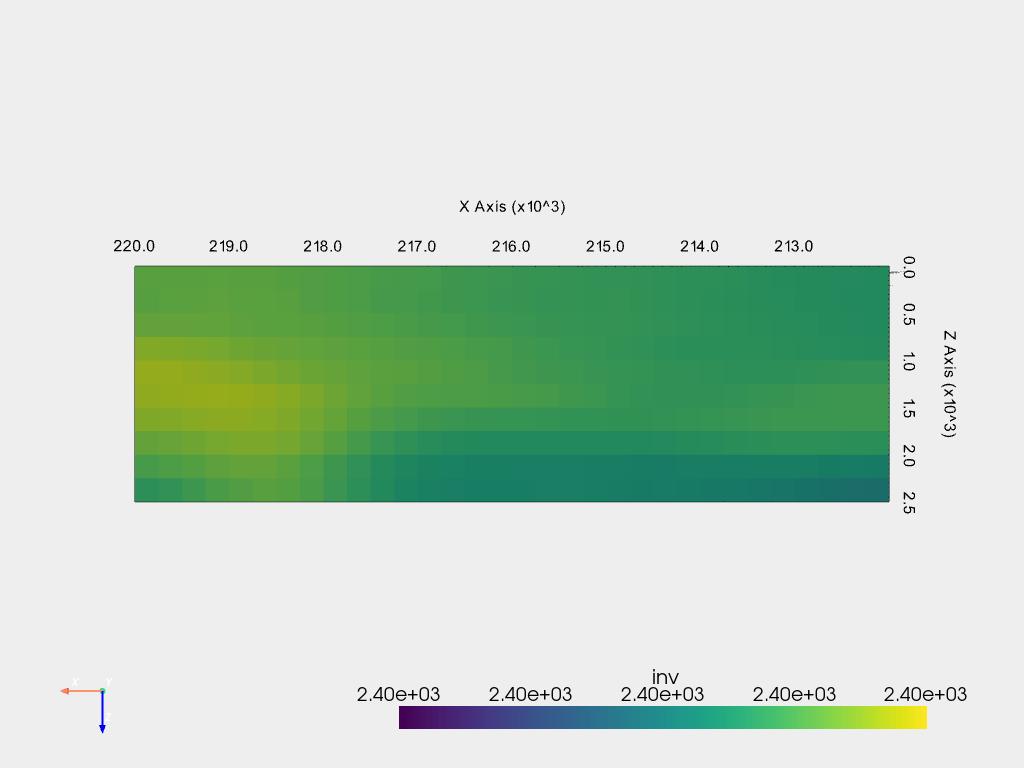

In [38]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 90
pl.camera.zoom(1.2)
_ = pl.show()

2023-07-29 19:00:16.032 ( 203.216s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.
2023-07-29 19:00:16.192 ( 203.375s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


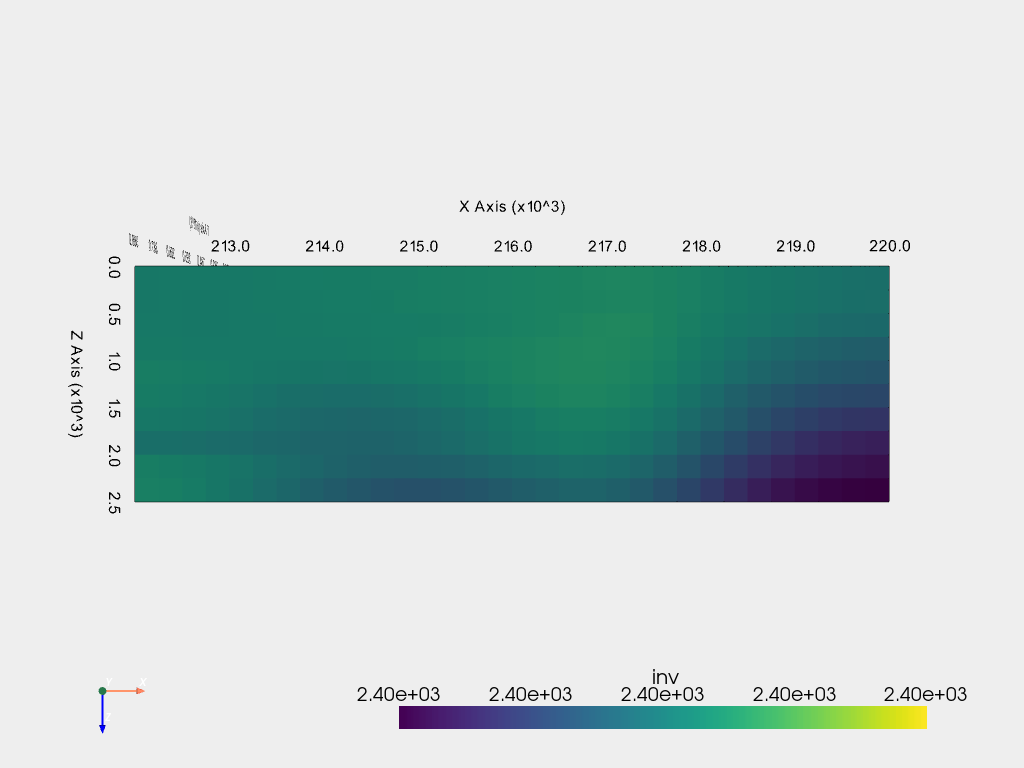

In [39]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 270
pl.camera.zoom(1.2)
_ = pl.show()

In [37]:
#lambda variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
#inv.modelTrans = pg.trans.TransCotLU(-2, 2)
#inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=2e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:15:20 - pyGIMLi - INFO - Starting inversion.


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14efb4200220>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x14ef93d2a6d0>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 29056 x 10240
calculating jacobian matrix (forced=1)...... 1.0412e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log)

data_misfit
124 [233.84960387647152,...,6294.708120621741]
mean data_misfit
2724.5444096211763
min data_misfit
207.09082942828536
max data_misfit
8343.884170658886


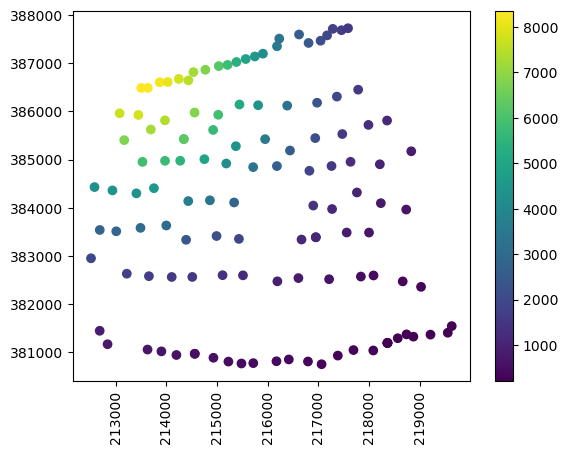

In [38]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

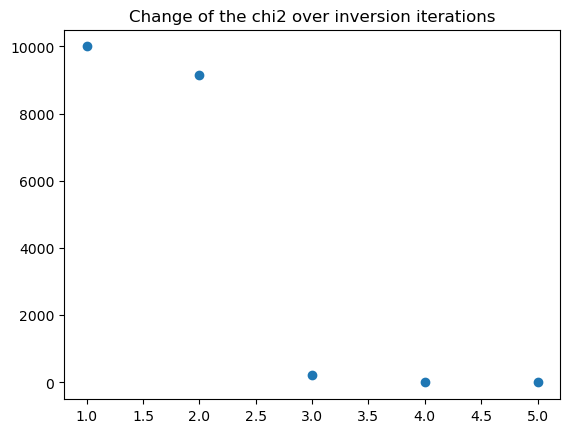

In [39]:
IIchi2=inv.chi2History
len(IIchi2)
n = len(IIchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,IIchi2)


In [40]:
IIchi2

[9999.166684027845,
 9141.602244459618,
 230.82686427989896,
 1.6996641014855578,
 0.00022341957981803802]

2023-07-29 19:02:17.639 ( 324.822s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.
2023-07-29 19:02:17.959 ( 325.142s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


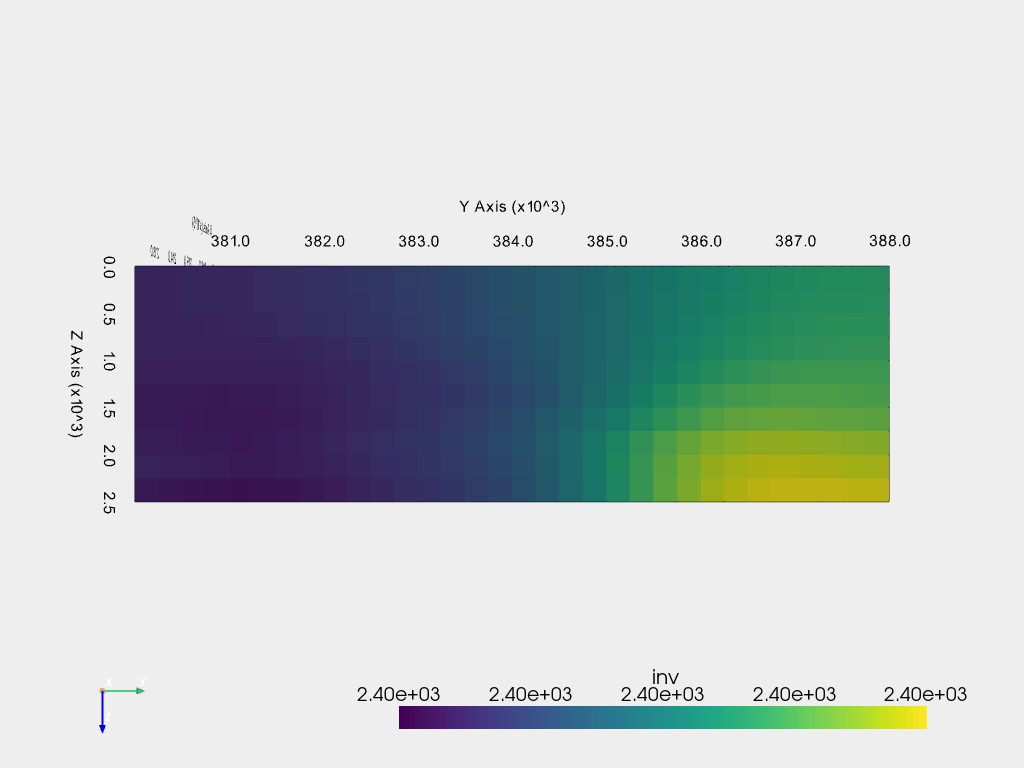

In [44]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180
pl.camera.zoom(1.2)
_ = pl.show()

In [45]:
#lambda variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
#inv.modelTrans = pg.trans.TransCotLU(-2, 2)
#inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=1e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:02:18 - pyGIMLi - INFO - Starting inversion.


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14a319e30c70>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14a2e19bcb20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x14a2e1e6fd10>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 29056 x 10240
calculating jacobian matrix (forced=1)...... 7.262e-06 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log) 

data_misfit
124 [11805.439330101013,...,10445.570609163493]
mean data_misfit
10221.643564765913
min data_misfit
7256.727874796838
max data_misfit
12454.688937332481


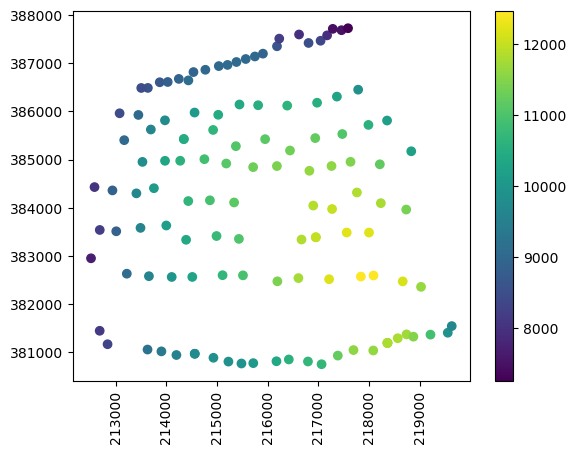

In [46]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

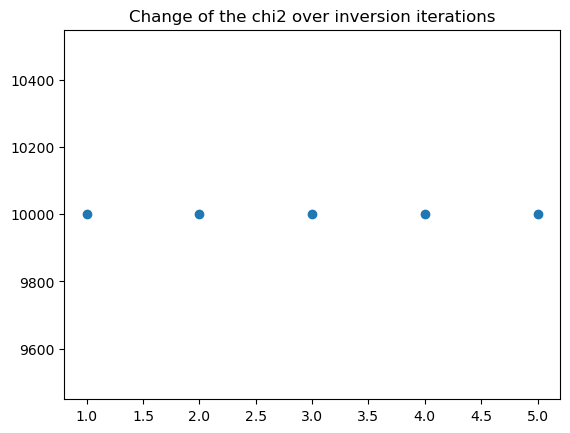

In [103]:
IIIchi2=inv.chi2History
len(IIIchi2)
n = len(IIIchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,IIIchi2)


In [48]:
IIIchi2

[9999.166684027743,
 9993.330586296946,
 9978.164167068599,
 9918.372524733995,
 7566.957834067282,
 4171.962854937032,
 1158.818871531309,
 4.638366056841713,
 0.001793124964348231]

In [49]:
#lambda variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
#inv.modelTrans = pg.trans.TransCotLU(-2, 2)
#inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=1e3,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:07:07 - pyGIMLi - INFO - Starting inversion.


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14a319e30c70>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14a2e12b9640>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x14a2e1e6fd10>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 29056 x 10240
calculating jacobian matrix (forced=1)...... 1.3905e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log)

data_misfit
124 [62945.30213971436,...,175148.02321209759]
mean data_misfit
126926.64536713643
min data_misfit
57566.611354500055
max data_misfit
360182.7317722216


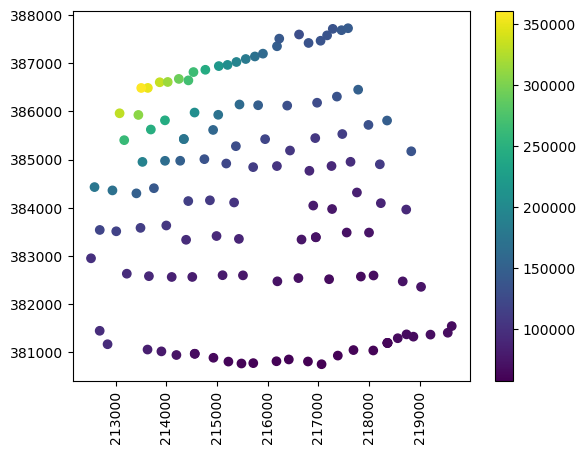

In [50]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

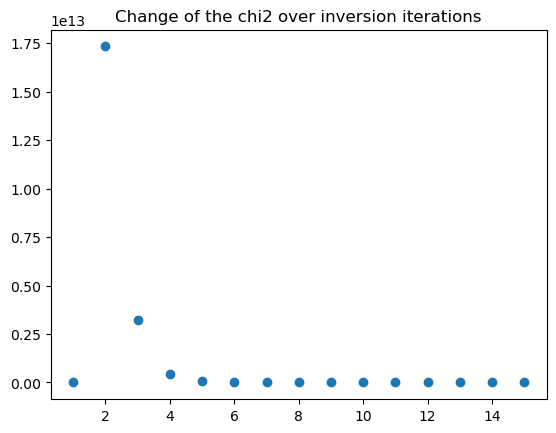

In [51]:
IVchi2=inv.chi2History
len(IVchi2)
n = len(IVchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,IVchi2)


In [52]:
IVchi2

[9999.166684027743,
 17335163215415.254,
 3207121753391.323,
 445936788012.98755,
 60656062037.820015,
 8213080056.192341,
 1109811619.8584921,
 149556210.23172012,
 20624283.875152063,
 2794761.0514321825,
 364149.58988858917,
 44440.350575363496,
 3475.7950809942,
 104.58586268432408,
 0.3688760489295001]

2023-07-29 19:10:04.728 ( 791.912s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.
2023-07-29 19:10:04.903 ( 792.086s) [        F97E1200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


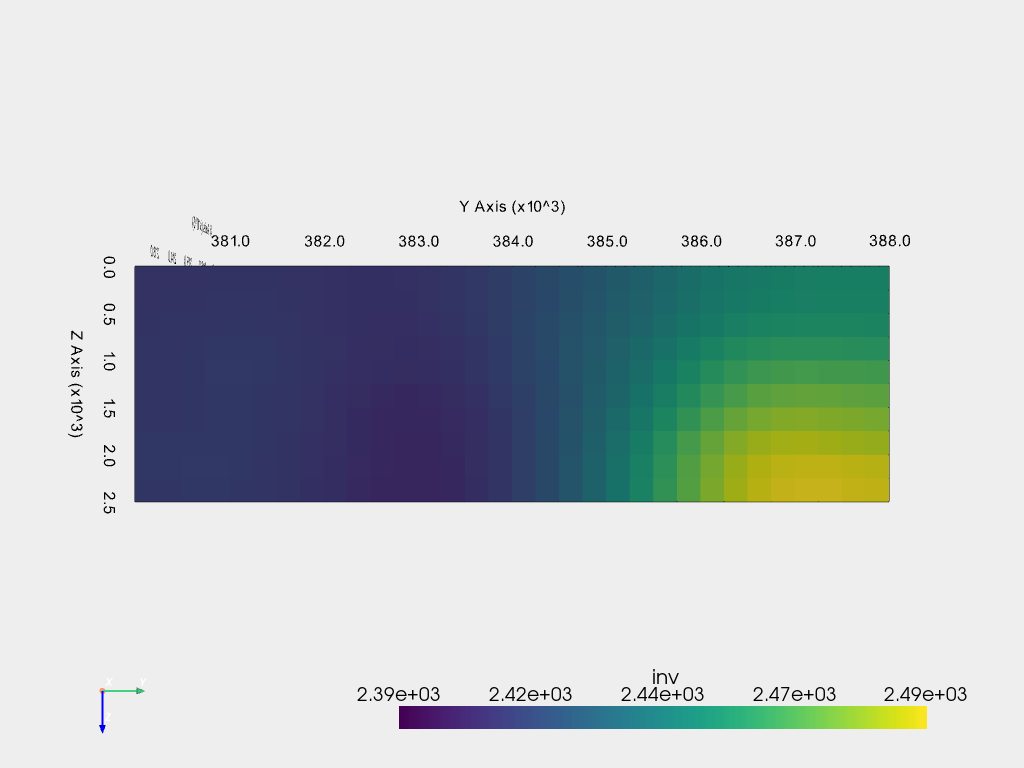

In [53]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180
pl.camera.zoom(1.2)
_ = pl.show()

In [41]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
#inv.modelTrans = pg.trans.TransCotLU(0, 3000)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=3e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:16:44 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 19:16:44 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0
29/07/23 - 19:16:44 - pyGIMLi - INFO - Creating forward mesh from region infos.


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14ef93d2b0a0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14efdd6eb5e0>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 19:16:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
29/07/23 - 19:16:47 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 88725 Cells: 81920 Boundaries: 129536
Mesh contains data: synth


ModellingBase::setMesh() copying new mesh ... 0.545947 s
FOP updating mesh dependencies ... 4.6892e-05 s


29/07/23 - 19:16:54 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 11): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 9.602e-06 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.2399e+06 + 6.9066e-28 * 30000 = 1.2399e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 30000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 362346; max = 7.53637e+09
1: LS newResponse: min = -1.15546e+13; max = -1.724e+11
1: rms/rrms(data, LS newResponse) = 3.35958e+12/1.39716e+07%
1: chi^2(data, LS newResponse, error, log) = 1.95204e+14
1: Phi = 2.42053e+16+0.034165*30000=2.42053e+16
Linesearch tau = 0.15
1: Model: min = 0.963537; max = 4.28129
1: Response: min

data_misfit
124 [13911742956.53497,...,119916020686.45488]
mean data_misfit
68485088407.46827
min data_misfit
12142122864.849642
max data_misfit
511690624750.3121


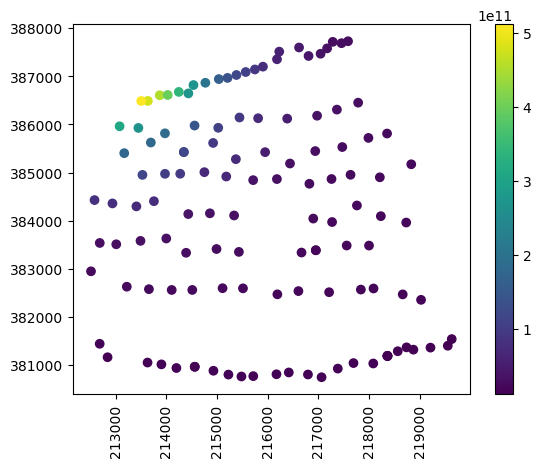

In [42]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

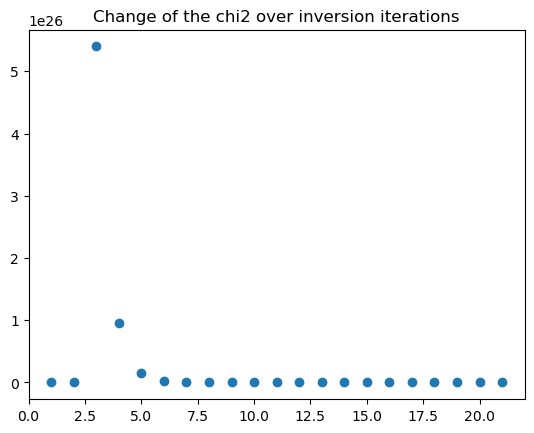

In [43]:
VIIIchi2=inv.chi2History
len(VIIIchi2)
n = len(VIIIchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,VIIIchi2)


In [44]:
VIIIchi2

[9999.166684027845,
 9983.02081408134,
 5.398701076546372e+26,
 9.566069361228083e+25,
 1.4566848037209123e+25,
 2.1007054026378635e+24,
 2.980398343149518e+23,
 4.193302896341544e+22,
 5.850085059392385e+21,
 8.097449249187647e+20,
 1.1176071443064537e+20,
 1.5348932869557238e+19,
 2.1024553258349504e+18,
 2.8693378143141933e+17,
 3.907031405730423e+16,
 5317658426218660.0,
 723641323087378.8,
 98416834567397.89,
 13365485143056.13,
 1814778862443.3508,
 246352947124.19336]

In [45]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=3e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:18:53 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 19:18:53 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14efdd6eb700>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14efff23f460>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 19:18:59 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 12): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 1.0958e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.2399e+06 + 6.9066e-28 * 30000 = 1.2399e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 30000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 362346; max = 7.53637e+09
1: LS newResponse: min = -1.15546e+13; max = -1.724e+11
1: rms/rrms(data, LS newResponse) = 3.35958e+12/1.39716e+07%
1: chi^2(data, LS newResponse, error, log) = 1.95204e+14
1: Phi = 2.42053e+16+0.034165*30000=2.42053e+16
Linesearch tau = 0.15
1: Model: min = 0.963537; max = 4.28129
1: Response: mi

data_misfit
124 [13911742956.53497,...,119916020686.45488]
mean data_misfit
68485088407.46827
min data_misfit
12142122864.849642
max data_misfit
511690624750.3121


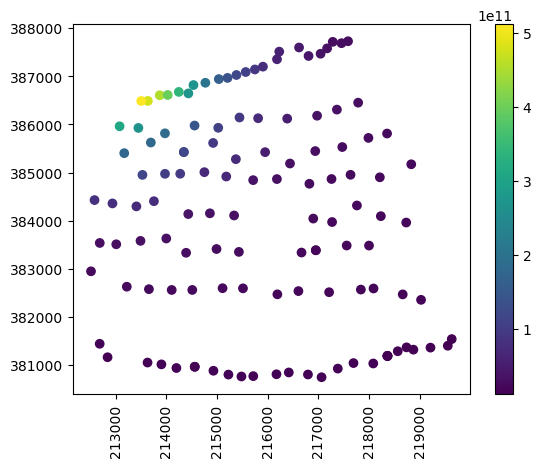

In [46]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

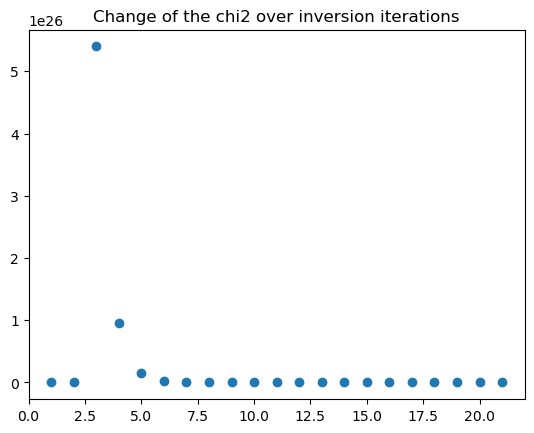

In [47]:
XIchi2=inv.chi2History
len(XIchi2)
n = len(XIchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,XIchi2)


In [48]:
XIchi2

[9999.166684027845,
 9983.02081408134,
 5.398701076546372e+26,
 9.566069361228083e+25,
 1.4566848037209123e+25,
 2.1007054026378635e+24,
 2.980398343149518e+23,
 4.193302896341544e+22,
 5.850085059392385e+21,
 8.097449249187647e+20,
 1.1176071443064537e+20,
 1.5348932869557238e+19,
 2.1024553258349504e+18,
 2.8693378143141933e+17,
 3.907031405730423e+16,
 5317658426218660.0,
 723641323087378.8,
 98416834567397.89,
 13365485143056.13,
 1814778862443.3508,
 246352947124.19336]

2023-07-29 19:21:06.724 ( 560.926s) [        B5302200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.
2023-07-29 19:21:06.906 ( 561.108s) [        B5302200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


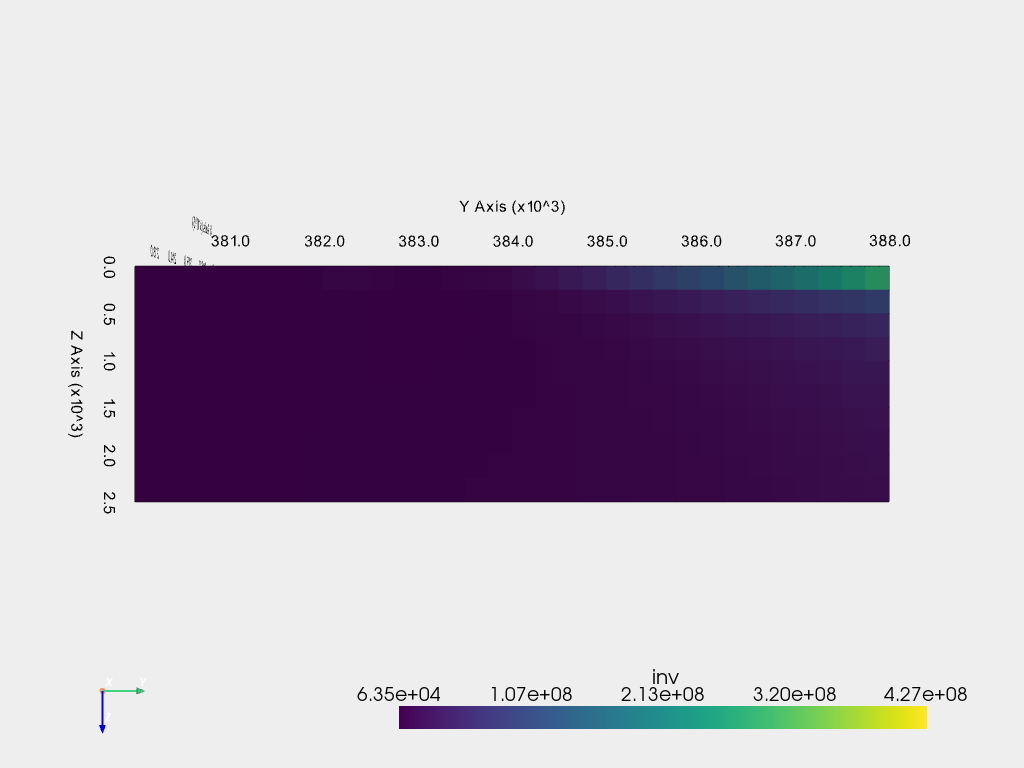

In [49]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180
pl.camera.zoom(1.2)
_ = pl.show()

In [50]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=1e4,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:21:07 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 19:21:07 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14ef93e875e0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14efdc06e460>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 19:21:13 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 13): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 2.1093e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.2399e+06 + 6.9066e-28 * 10000 = 1.2399e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 10000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 4.41626e+18; max = 3.78239e+31
1: LS newResponse: min = -1.02265e+34; max = -6.30688e+31
1: rms/rrms(data, LS newResponse) = 2.43376e+33/1.02432e+28%
1: chi^2(data, LS newResponse, error, log) = 1.04922e+56
1: Phi = 1.30104e+58+0.30647*10000=1.30104e+58
Linesearch tau = 0.15
1: Model: min = 88.4623; max = 7703.09
1: Respons

data_misfit
124 [1113.4648323915899,...,10298.092217925936]
mean data_misfit
6750.111776837989
min data_misfit
997.8973195701838
max data_misfit
53834.950343064964


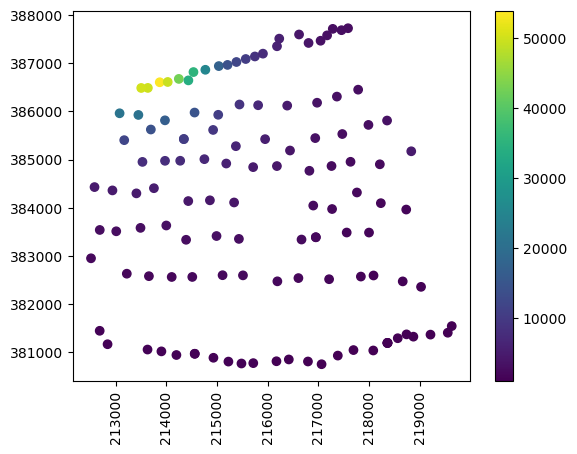

In [51]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

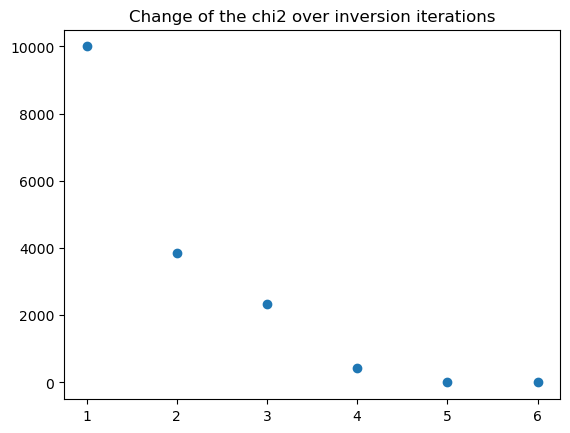

In [52]:
Xchi2=inv.chi2History
len(Xchi2)
n = len(Xchi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,Xchi2)


In [53]:
Xchi2

[9999.166684027845,
 3853.156278572866,
 2323.4819427262155,
 433.86886422361346,
 1.438537620734065,
 0.002761315611669852]

In [54]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
_ = pl.show()

2023-07-29 19:22:26.783 ( 640.985s) [        B5302200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


In [ ]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, style="wireframe",
                filter={"threshold": ftr}, 
                hold=True, backend="trame")
ftr = dict(value=0.1, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", 
            filter={"threshold": ftr}
           )
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180
pl.camera.zoom(1.2)
_ = pl.show()

In [55]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=1e4,  # zWeight=0.3,
                   startModel=0.25, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:22:27 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 19:22:27 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14efb4200760>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14ef8d92b520>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.25/0.25
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 19:22:33 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 14): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 1.1714e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -2880.76 max response = -1905.47 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44399e+07/99.9896%
0: chi^2(data, response, error, log) = 9997.92
0: Phi = 1.23974e+06 + 1.61657e-28 * 10000 = 1.23974e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 10000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 7.60313e+47; max = 6.24667e+79
1: LS newResponse: min = -3.8066e+81; max = -2.22793e+79
1: rms/rrms(data, LS newResponse) = 8.46862e+80/3.56861e+75%
1: chi^2(data, LS newResponse, error, log) = 1.2735e+151
1: Phi = 1.57914e+153+1.86635*10000=1.57914e+153
Linesearch tau = 0.15
1: Model: min = 4.68164e+06; max = 2.86811e

In [56]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=1e4,  # zWeight=0.3,
                   startModel=0.5, verbose=True)
grid["inv"] = invmodel

min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06


29/07/23 - 19:25:23 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 19:25:23 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0


fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14ef9430cc40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14ef8d92b4c0>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.5/0.5
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 19:25:30 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 15): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 1.0504e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -5761.52 max response = -3810.95 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44373e+07/99.9792%
0: chi^2(data, response, error, log) = 9995.83
0: Phi = 1.23948e+06 + 4.04142e-29 * 10000 = 1.23948e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 10000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 2.55307e+92; max = 2.62954e+153
1: LS newResponse: min = -5.20623e+154; max = -2.62788e+152
1: rms/rrms(data, LS newResponse) = inf/4.67332e+148%
1: chi^2(data, LS newResponse, error, log) = 2.18399e+297
1: Phi = 2.70815e+299+6.82231*10000=2.70815e+299
Linesearch tau = 0.15
1: Model: min = 4.02888e+13; max = 5.71619e+2

In [61]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=5e3,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 19:37:14 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 19:37:14 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[500, 500, 100], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14ef93fb2760>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14ef8d93af40>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(dweight) = 3.61594e-06/5.46671e-06
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 19:37:20 - pyGIMLi - INFO - Cache /cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/pygimli/math/matrix.py:createCm05 restored (743.1s x 20): /home/yq015632/.cache/pygimli/13046752814859967862


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 1.1002e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.2399e+06 + 6.9066e-28 * 5000 = 1.2399e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 5000
tau = 0. Trying parabolic line search with step length 0.3 ==> tau = 0.15
1: LS newModel: min = 1.54683e+38; max = 9.74891e+63
1: LS newResponse: min = -8.48241e+65; max = -5.12021e+63
1: rms/rrms(data, LS newResponse) = 1.9136e+65/8.06137e+59%
1: chi^2(data, LS newResponse, error, log) = 6.49856e+119
1: Phi = 8.05822e+121+1.21972*5000=8.05822e+121
Linesearch tau = 0.15
1: Model: min = 75581.6; max = 5.602e+08
1: Respon

data_misfit
124 [5809.7413484193385,...,140313.07029194757]
mean data_misfit
93442.79918573856
min data_misfit
5113.783253531903
max data_misfit
899964.7319757529


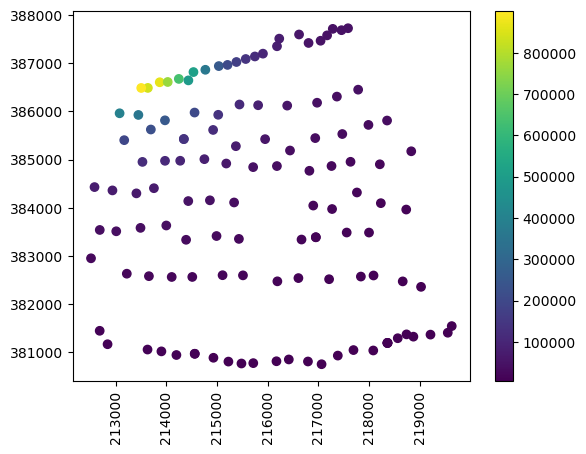

In [62]:
data_misfit=data-inv.response
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)

plt.scatter(d_obs_x,d_obs_y, c=data_misfit)
plt.colorbar()
plt.xticks(rotation=90)
#data_misfit, np.mean(data_misfit), min(data_misfit), max(data_misfit)
print('data_misfit')
print(data_misfit)
print('mean data_misfit')
print(np.mean(data_misfit))
print('min data_misfit')
print(min(data_misfit))
print('max data_misfit')
print(max(data_misfit))

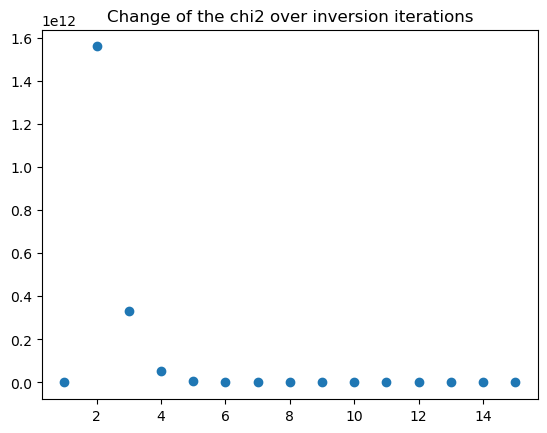

In [63]:
chi2=inv.chi2History
len(chi2)
n = len(chi2)  
iteration = np.arange(1, n + 1)
iteration
plt.title('Change of the chi2 over inversion iterations')
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(iteration,chi2)


In [64]:
chi2

[9999.166684027845,
 1558373845382.9575,
 330349424230.48804,
 53714237285.06731,
 7375811290.577575,
 1001954935.1824733,
 135546747.11558414,
 18225913.26500607,
 2426369.1994707417,
 320430.2375274787,
 42833.63178375157,
 5752.365342373365,
 539.7377422764527,
 44.32614336900707,
 0.6861479925393638]

2023-07-29 22:15:23.729 (11017.931s) [        B5302200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


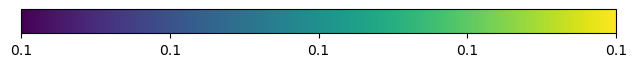

In [105]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})

pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

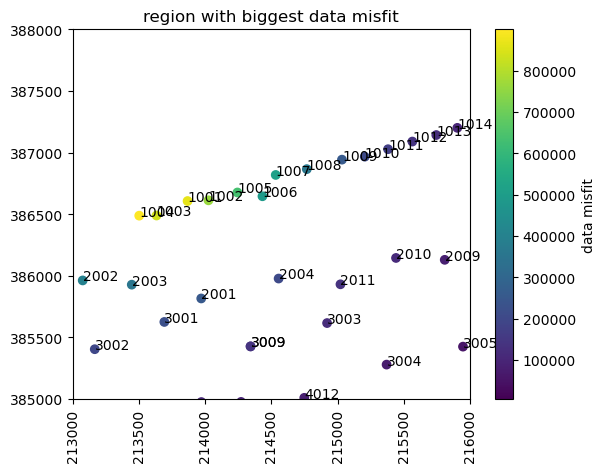

In [111]:
#observed data
for i, txt in enumerate(df['ID']):
    plt.annotate(txt, (df['X'][i], df['Y'][i]))

plt.scatter(df['X'], df['Y'], c=data_misfit
            , cmap='viridis')
plt.xticks(rotation=90)
plt.colorbar(label="data misfit")
plt.title('region with biggest data misfit')
plt.xlim(213000,216000)
plt.ylim(385000,388000)
plt.plot()
plt.show()

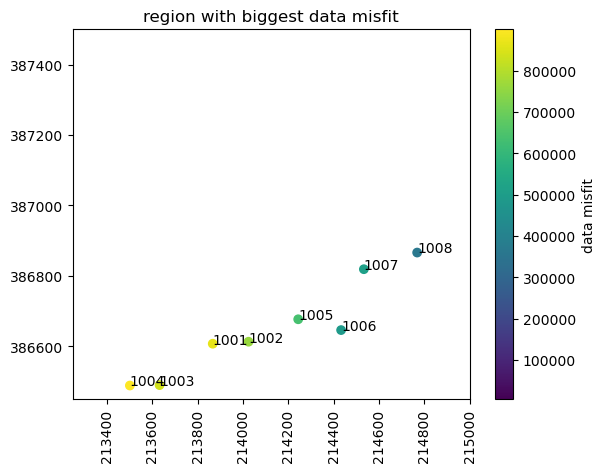

In [112]:
#zoom in
#observed data
for i, txt in enumerate(df['ID']):
    plt.annotate(txt, (df['X'][i], df['Y'][i]))

plt.scatter(df['X'], df['Y'], c=data_misfit
            , cmap='viridis')
plt.xticks(rotation=90)
plt.colorbar(label="data misfit")
plt.title('region with biggest data misfit')
plt.xlim(213250,215000)
plt.ylim(386450,387500)
plt.plot()
plt.show()

In [113]:
#delete 1001-1005

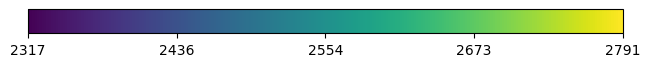

In [89]:

pl, _ = pg.show(grid, hold=True, alpha=0.3)
drawSlice(pl, grid, normal=[-1,1,0], label="inv")

pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()



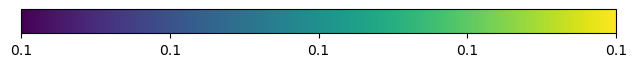

In [118]:

pl, _ = pg.show(grid, hold=True, alpha=0.3)
drawSlice(pl, grid, normal=[1.75,1.75,2], label="inv")

pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()



In [ ]:
### grid.exportVTK('vtk')

In [101]:
#constraints variations
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
inv.modelTrans = pg.trans.TransCotLU(2000, 2800)
inv.setRegularization(correlationLengths=[50, 50, 10])
inv.setConstraintWeights(wz)
invmodel = inv.run(data, lam=5e3,  # zWeight=0.3,
                   startModel=0.1, verbose=True)
grid["inv"] = invmodel

29/07/23 - 20:48:09 - pyGIMLi - INFO - Starting inversion.
29/07/23 - 20:48:09 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[50, 50, 10], dip=0, strike=0


min/max(cWeight) = 0.040404/0.444444
min/max(dweight) = 3.61594e-06/5.46671e-06
fop: <__main__.GravityModelling object at 0x14efdc019a40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14edf9402b20>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x14ef939be2e0>
min/max (data): -2.8e+07/-1.8e+07
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 3.61594e-06/5.46671e-06
Building constraints matrix


29/07/23 - 20:57:01 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 525.3s
29/07/23 - 20:57:02 - pyGIMLi - INFO - Cache stored: /home/yq015632/.cache/pygimli/9986530352742534309


constraint matrix of size(nBounds x nModel) 10240 x 10240
calculating jacobian matrix (forced=1)...... 2.5272e-05 s
min data = -2.76553e+07 max data = -1.82926e+07 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1152.3 max response = -762.19 (124)
calc without reference model
0: rms/rrms(data, response) = 2.44414e+07/99.9958%
0: chi^2(data, response, error, log) = 9999.17
0: Phi = 1.2399e+06 + 2.69164e-28 * 5000 = 1.2399e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 5000


29/07/23 - 20:57:16 - Core - ERROR - Model contains nan values.
29/07/23 - 20:57:16 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
--------------------------------------------------------------------------------
inv.iter 2 ... calculating jacobian matrix (forced=1)...... 1.2433e-05 s
solve CGLSCDWWtrans with lambda = 5000


29/07/23 - 20:57:29 - Core - ERROR - Model contains nan values.
29/07/23 - 20:57:29 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
--------------------------------------------------------------------------------
inv.iter 3 ... calculating jacobian matrix (forced=1)...... 1.4075e-05 s
solve CGLSCDWWtrans with lambda = 5000


29/07/23 - 20:57:42 - Core - ERROR - Model contains nan values.
29/07/23 - 20:57:42 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
--------------------------------------------------------------------------------
inv.iter 4 ... calculating jacobian matrix (forced=1)...... 1.4462e-05 s
solve CGLSCDWWtrans with lambda = 5000


29/07/23 - 20:57:55 - Core - ERROR - Model contains nan values.
29/07/23 - 20:57:56 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.17 (dPhi = 0.0%) lam: 5000.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 2.0%)                  #
################################################################################


2023-07-29 20:02:15.707 (3029.909s) [        B5302200]       vtkThreshold.cxx:87    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


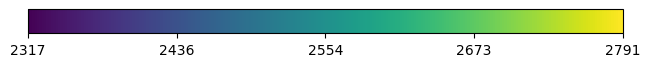

In [72]:
pl, _ = pg.show(grid, style="wireframe", hold=True, alpha=0.01)
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "xz"
pl.camera.roll = 0
pl.camera.azimuth = 20
pl.camera.elevation = 50
pl.camera.zoom(1.2)
pg.viewer.mpl.createColorBarOnly(
    cMin=min(grid['inv']), cMax=max(grid['inv']),
    logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)
_ = pl.show()

In [ ]:
slice = pg.meshtools.extract2dSlice(grid, origin=[xmin, ymin, zmin], normal=[1, 1, 0])
_, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
pg.show(slice, "synth", ax=ax[0])
pg.show(slice, "inv", ax=ax[1])
ax[0].set_ylim(ax[0].get_ylim()[::-1])

## References
-  Li, Y. & Oldenburg, D. (1998): 3-D inversion of gravity data. Geophysics 63(1), 109-119.
-  Holstein, H., Sherratt, E.M., Reid, A.B.  (2007): Gravimagnetic field
   tensor gradiometry formulas for uniform polyhedra, SEG Ext. Abstr.


